## **Import Statements**

In [499]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import OrdinalEncoder
from io import StringIO
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lazypredict.Supervised import LazyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder

## **Load and inspect Files**

In [2]:
features = pd.read_csv(r'c:\Users\Yash\Desktop\final-retail_sales_forecast\Features_data_set.csv')
sales = pd.read_csv(r'c:\Users\Yash\Desktop\final-retail_sales_forecast\sales_data_set.csv')
stores = pd.read_csv(r'c:\Users\Yash\Desktop\final-retail_sales_forecast\stores_data_set.csv')

In [23]:
features.head()

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  \
0      1 2010-02-05        42.31        2.57        NaN        NaN        NaN   
1      1 2010-02-12        38.51        2.55        NaN        NaN        NaN   
2      1 2010-02-19        39.93        2.51        NaN        NaN        NaN   
3      1 2010-02-26        46.63        2.56        NaN        NaN        NaN   
4      1 2010-03-05        46.50        2.62        NaN        NaN        NaN   

   MarkDown4  MarkDown5    CPI  Unemployment  IsHoliday  
0        NaN        NaN 211.10          8.11      False  
1        NaN        NaN 211.24          8.11       True  
2        NaN        NaN 211.29          8.11      False  
3        NaN        NaN 211.32          8.11      False  
4        NaN        NaN 211.35          8.11      False

In [20]:
sales.head()

Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False

In [5]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

### **Convert Datetime columns**

In [6]:
sales['Date'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y')
features['Date'] = pd.to_datetime(features['Date'], format='%d/%m/%Y')

### **Percentage Of Null Values**

In [96]:
percentage_null_CPI = (features['CPI'].isnull().sum() / len(features['CPI'])) * 100
percentage_null_Unemployment = (features['Unemployment'].isnull().sum() / len(features['Unemployment'])) * 100
print("__Percentage Of Null Values__")
[print(f"percentage_null_MarkDown{i} : {(features[f'MarkDown{i}'].isnull().sum() / len(features[f'MarkDown{i}'])) * 100}") for i in range(1, 6)]
print("percentage_of_CPI :", percentage_null_CPI)
print("percentage_of_Unemployment :", percentage_null_Unemployment)

__Percentage Of Null Values__
percentage_null_MarkDown1 : 50.76923076923077
percentage_null_MarkDown2 : 64.33455433455434
percentage_null_MarkDown3 : 55.885225885225886
percentage_null_MarkDown4 : 57.7045177045177
percentage_null_MarkDown5 : 50.54945054945055
percentage_of_CPI : 7.142857142857142
percentage_of_Unemployment : 7.142857142857142


### **Store Type Distribution**

In [27]:
merged_data = pd.merge(sales, stores, on='Store')

In [32]:
merged_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size
0      1     1 2010-02-05      24924.50      False    A  151315
1      1     1 2010-02-12      46039.49       True    A  151315
2      1     1 2010-02-19      41595.55      False    A  151315
3      1     1 2010-02-26      19403.54      False    A  151315
4      1     1 2010-03-05      21827.90      False    A  151315

### **Store Type Distribution**

In [48]:
fig = px.sunburst(merged_data, path=['Type', 'Store'], title='Store Distribution by Type')
fig.show()

In [47]:
merged_data['Year'] = pd.to_datetime(merged_data['Date']).dt.year
grouped_data = merged_data.groupby(['Type', 'Store', 'Year'])['Weekly_Sales'].mean().reset_index()
grouped_data['GrowthRate'] = grouped_data.groupby(['Type', 'Store'])['Weekly_Sales'].pct_change() * 100 # percent change by Weekly_Sales
grouped_data['AverageSales'] = grouped_data.groupby(['Type', 'Store'])['Weekly_Sales'].transform('mean')
growth_rate_data = grouped_data[['Year', 'Store', 'Type', 'GrowthRate', 'AverageSales']].copy()

In [50]:
growth_rate_data.head(5)

Year  Store Type  GrowthRate  AverageSales
0  2010      1    A         NaN      21727.04
1  2011      1    A        2.04      21727.04
2  2012      1    A        2.12      21727.04
3  2010      2    A         NaN      26896.30
4  2011      2    A       -4.86      26896.30

### **Average Growth Rate by Store and Type**

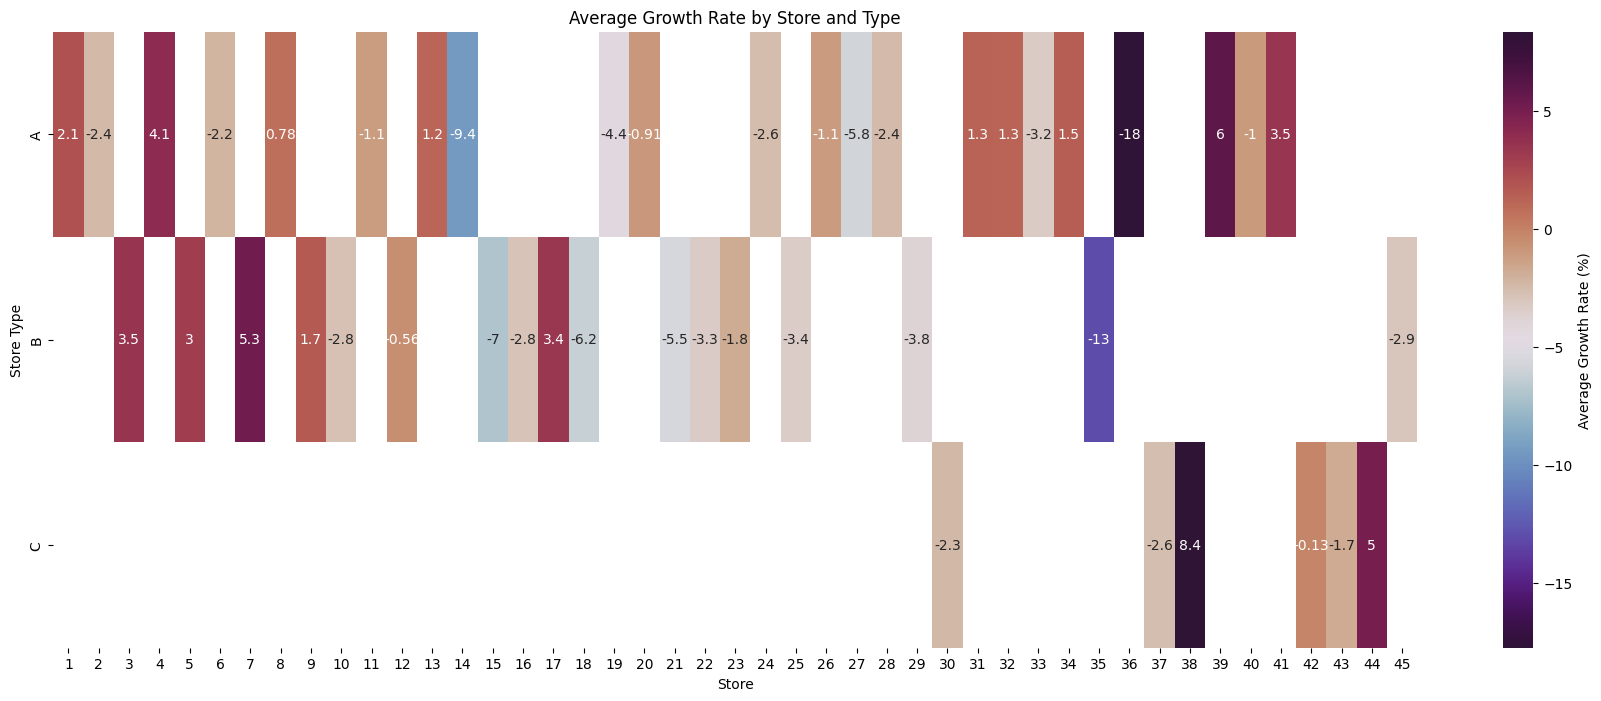

In [53]:
heatmap_data = growth_rate_data.pivot_table(
    values='GrowthRate',
    index='Type',
    columns='Store',
    aggfunc='mean',
)

plt.figure(figsize=(22, 8))

sns.heatmap(
    heatmap_data,
    annot=True, 
    cmap='twilight_shifted', 
    cbar_kws={'label': 'Average Growth Rate (%)'},
)

plt.xlabel('Store')
plt.ylabel('Store Type')
plt.title('Average Growth Rate by Store and Type')

plt.show()

## **Distribution of Departments in Sales dataframe**

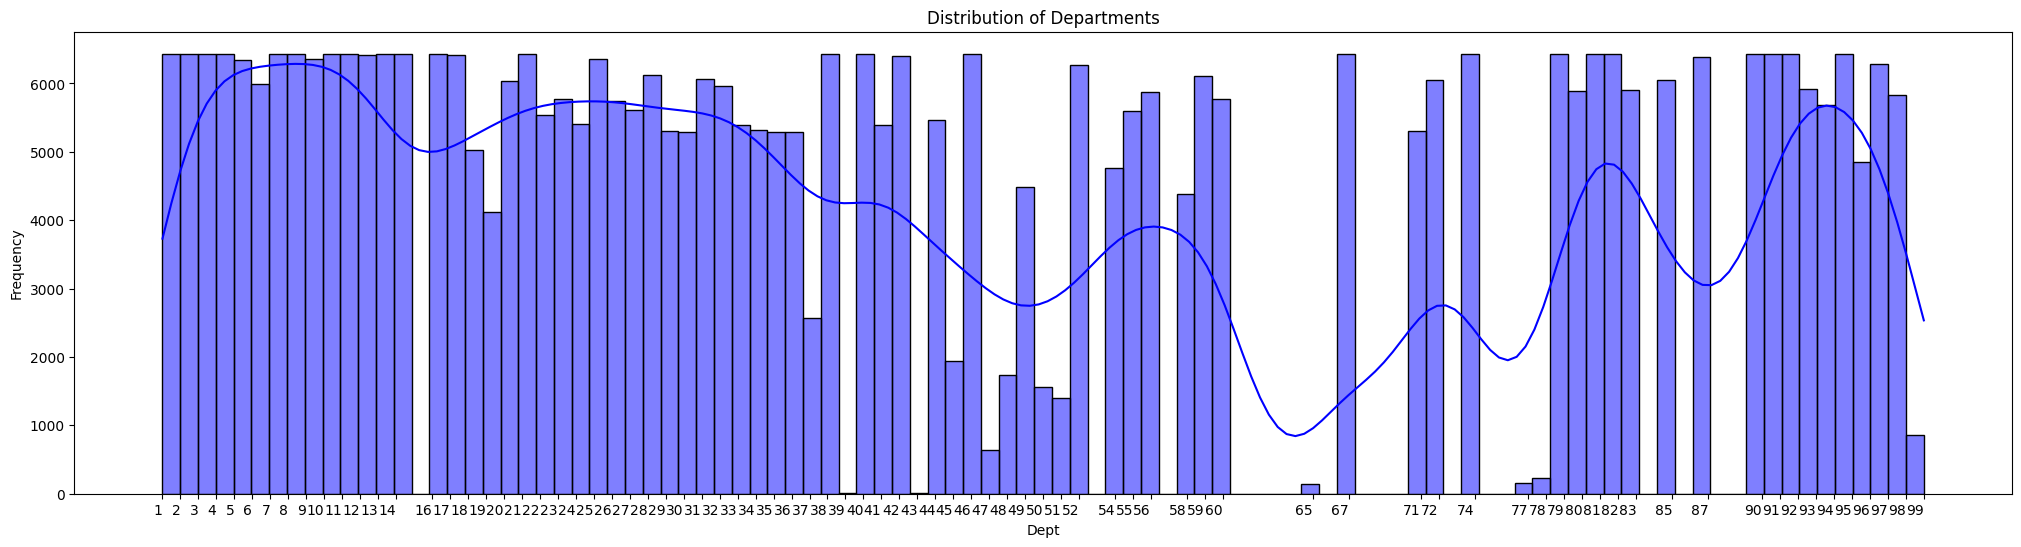

In [57]:
plt.figure(figsize=(25, 6))
sns.histplot(sales['Dept'], kde=True, color='blue', bins=99)
plt.title('Distribution of Departments')
plt.xlabel('Dept')
plt.ylabel('Frequency')
plt.xticks(sales['Dept'].unique(), ha="right")
plt.show()

### **Dept's with Negative Sales**

In [98]:
column_names = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
statistics_features = features[column_names].describe().T
statistics_features['negative values'] = [features[col][features[col] < 0].count() for col in column_names]
statistics_features['null values'] = [features[col].isnull().sum() for col in column_names]
statistics_features['percentage of null values'] = [(features[col].isnull().sum() / len(features[col])) * 100 for col in column_names]
statistics_features = statistics_features.T
statistics_features

MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
count                        4032.00    2921.00    3613.00    3464.00   
mean                         7032.37    3384.18    1760.10    3292.94   
std                          9262.75    8793.58   11276.46    6792.33   
min                         -2781.45    -265.76    -179.26       0.22   
25%                          1577.53      68.88       6.60     304.69   
50%                          4743.58     364.57      36.26    1176.42   
75%                          8923.31    2153.35     163.15    3310.01   
max                        103184.98  104519.54  149483.31   67474.85   
negative values                 4.00      25.00      13.00       0.00   
null values                  4158.00    5269.00    4577.00    4726.00   
percentage of null values      50.77      64.33      55.89      57.70   

                           MarkDown5  
count                        4050.00  
mean                         4132.22  
std                         13086.69  
min                          -185.17  
25%                          1440.83  
50%                          2727.14  
75%                          4832.56  
max                        771448.10  
negative values                 2.00  
null values                  4140.00  
percentage of null values      50.55

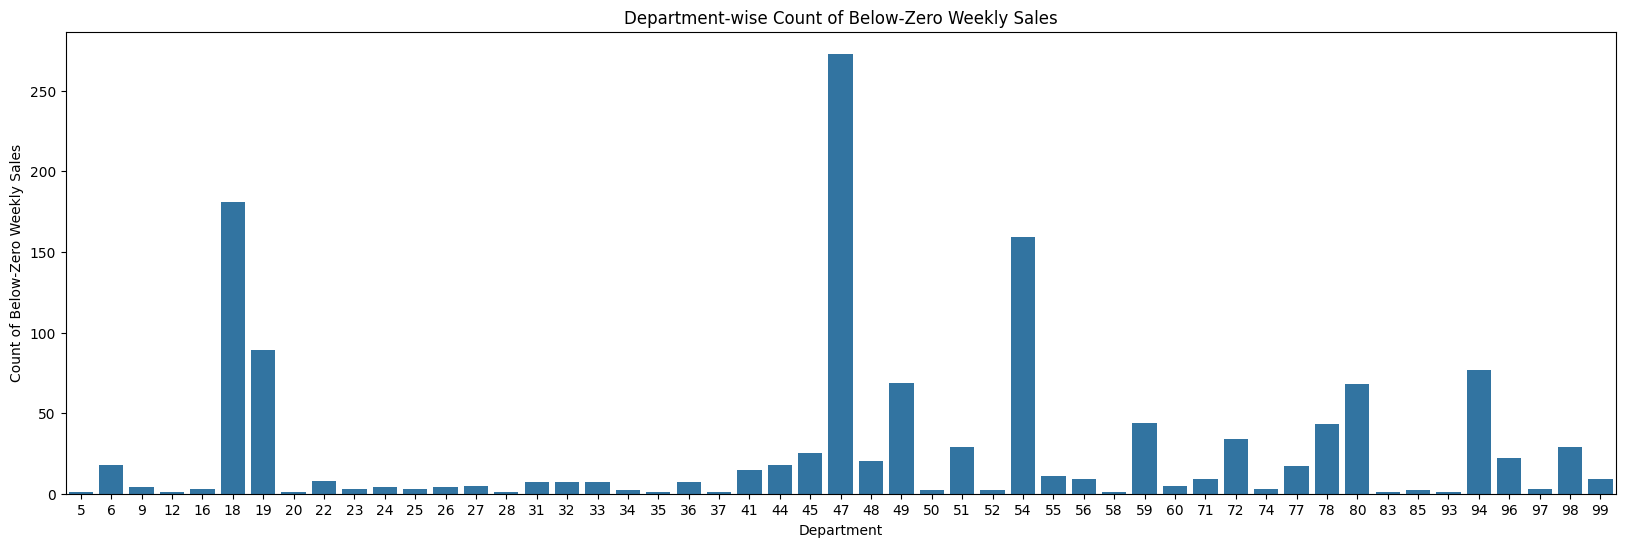

In [61]:
below_zero_sales_by_department = sales[sales['Weekly_Sales'] <= 0].groupby('Dept').size().reset_index(name='Zero_Sales_Count')
plt.figure(figsize=(20, 6))
sns.barplot(x='Dept', y='Zero_Sales_Count', data=below_zero_sales_by_department)
plt.xlabel('Department')
plt.ylabel('Count of Below-Zero Weekly Sales')
plt.title('Department-wise Count of Below-Zero Weekly Sales')
plt.show()

#### **Chart to check the growth of each Store and sort out Top 10 Stores**

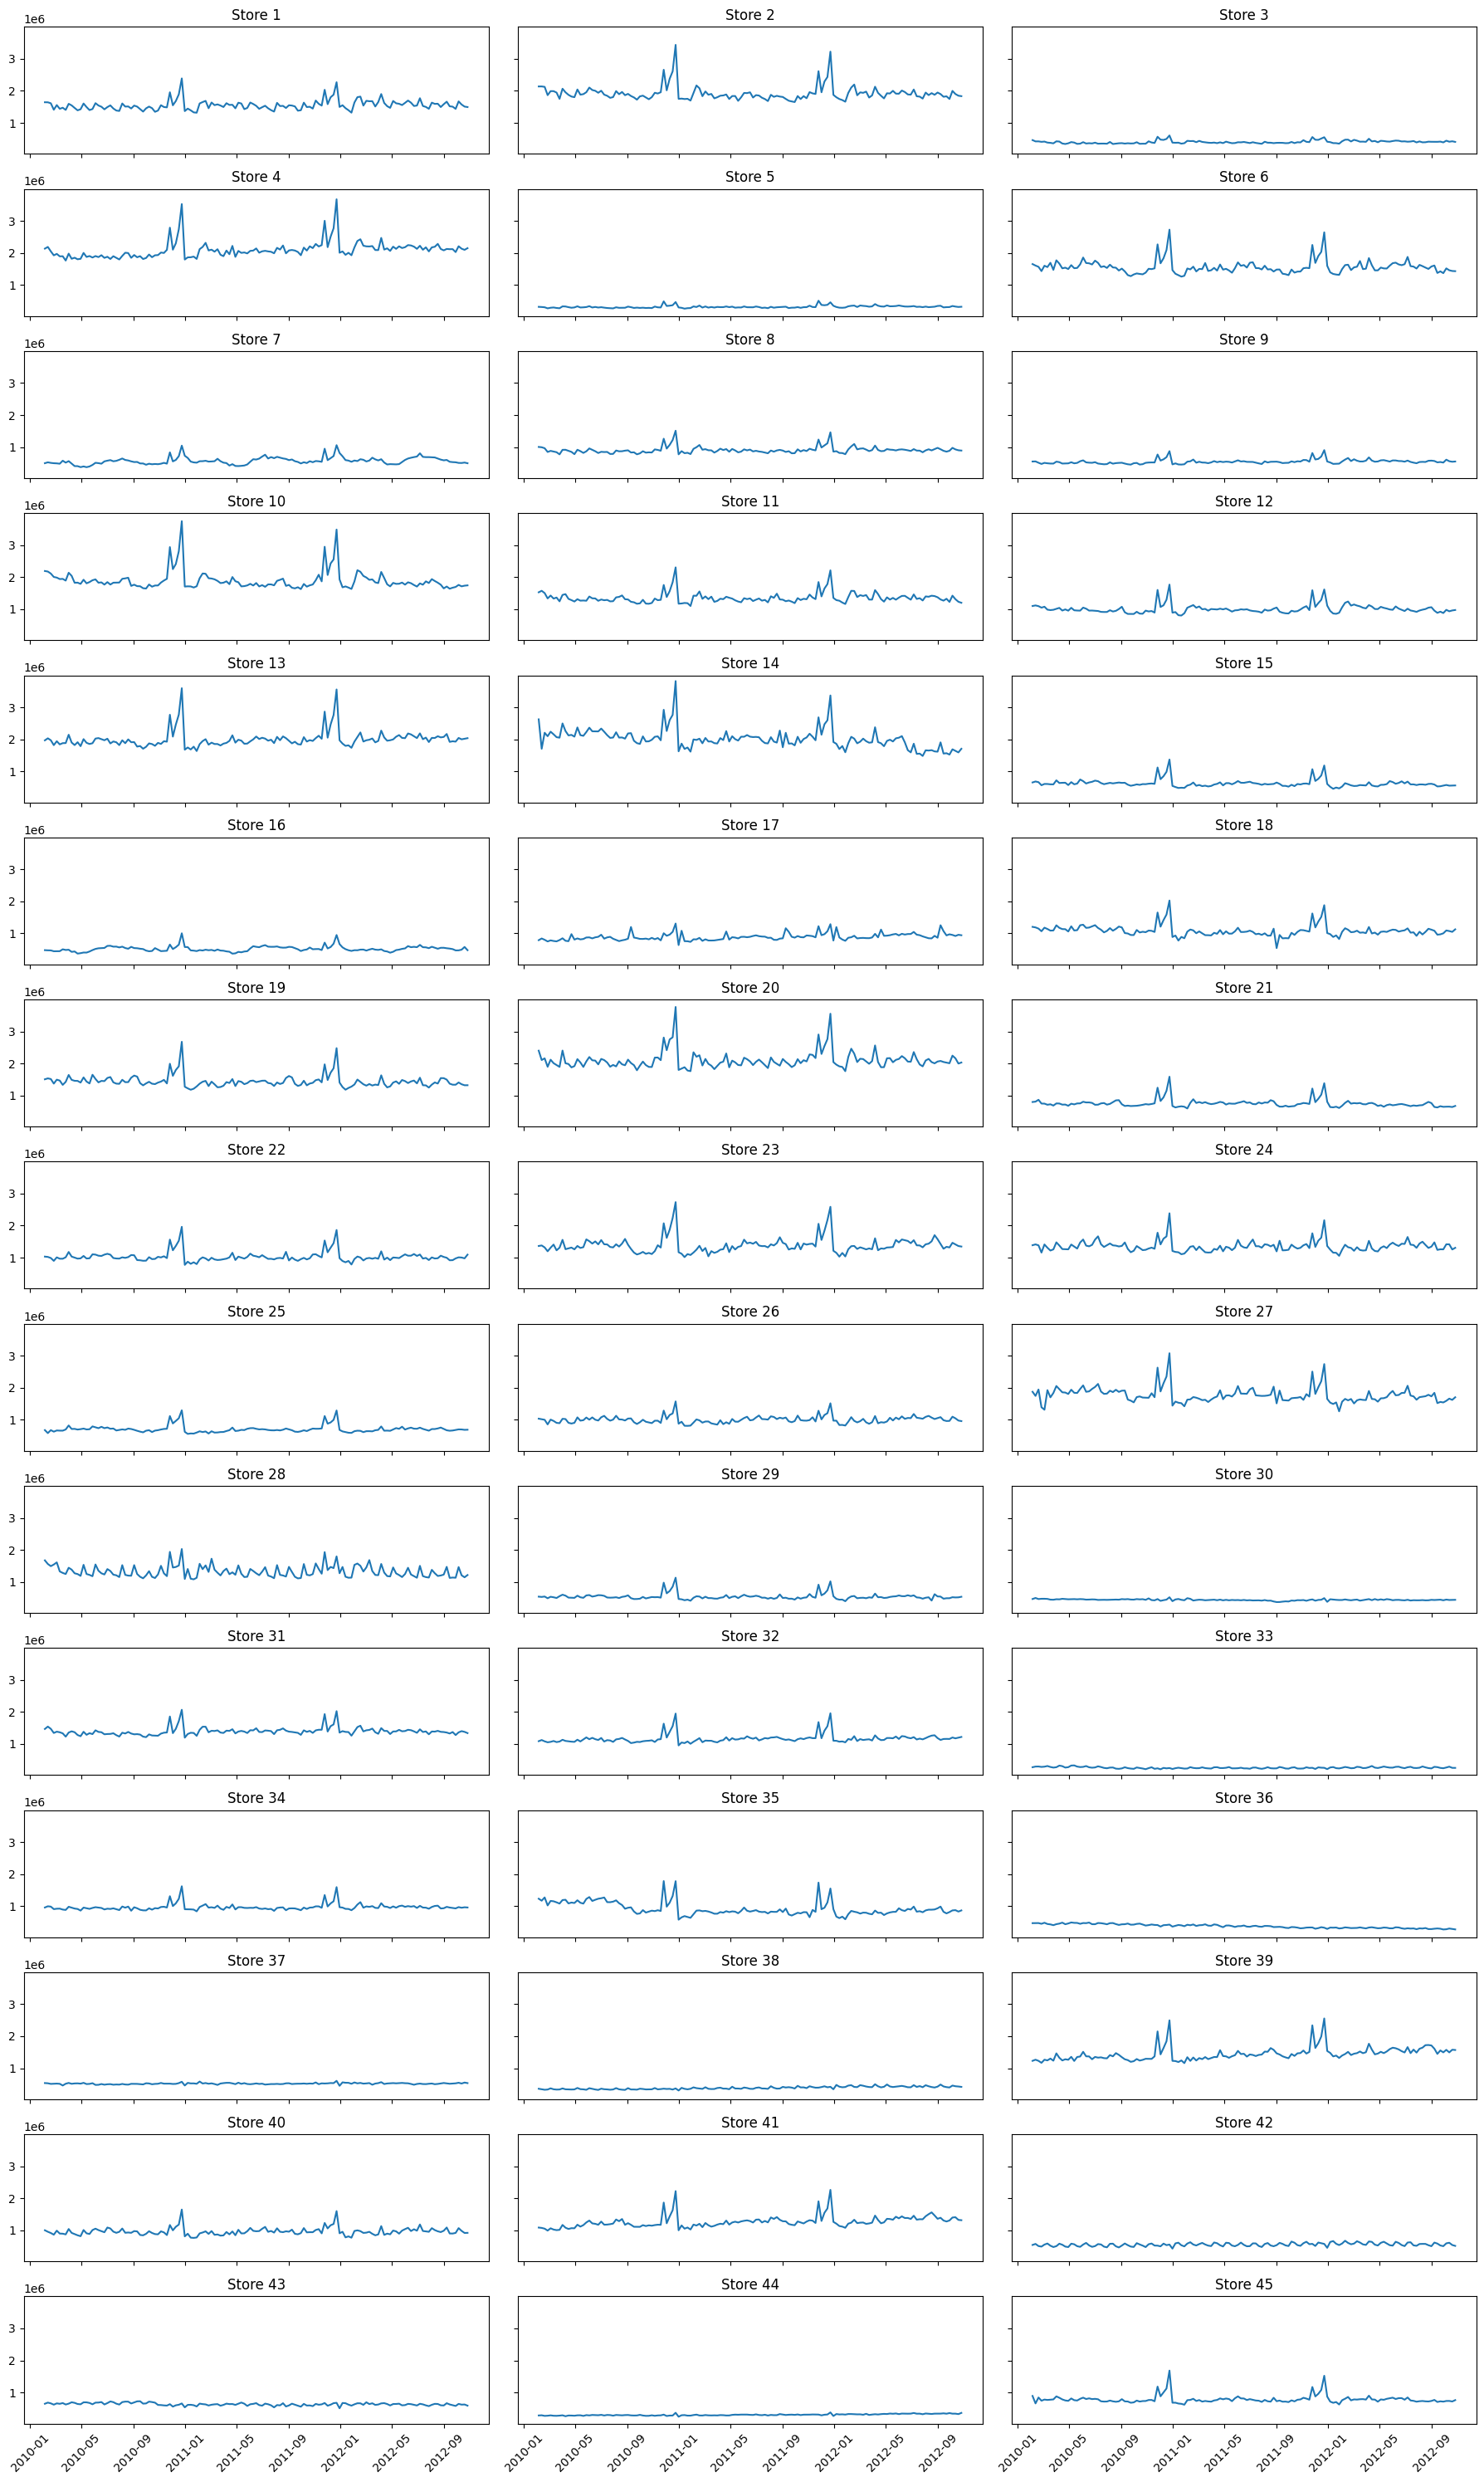

In [107]:
store_numbers = range(1, 46)
fig, axes = plt.subplots(nrows=15, ncols=3, figsize=(18, 30), sharex=True, sharey=True)
axes = axes.flatten()
for i, store_num in enumerate(store_numbers):
    store_data = sales[sales['Store'] == store_num]

    weekly_sales = store_data.groupby('Date')['Weekly_Sales'].sum()

    axes[i].plot(weekly_sales.index, weekly_sales, label=f'Store {store_num}')
    axes[i].set_title(f'Store {store_num}')

    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [981]:
top_stores = sales.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

#### **Top 10 Stores by Total Sales**

In [982]:
top_stores

Store
20   301397792.46
4    299543953.38
14   288999911.34
13   286517703.80
2    275382440.98
10   271617713.89
27   253855916.88
6    223756130.64
1    222402808.85
39   207445542.47
19   206634862.10
31   199613905.50
23   198750617.85
24   194016021.28
11   193962786.80
28   189263680.58
41   181341934.89
32   166819246.16
18   155114734.21
22   147075648.57
12   144287230.15
26   143416393.79
34   138249763.00
40   137870309.79
35   131520672.08
8    129951181.13
17   127782138.83
45   112395341.42
21   108117878.92
25   101061179.17
43    90565435.41
15    89133683.92
7     81598275.14
42    79565752.43
9     77789218.99
29    77141554.31
16    74252425.40
37    74202740.32
30    62716885.12
3     57586735.07
38    55159626.42
36    53412214.97
5     45475688.90
44    43293087.84
33    37160221.96
Name: Weekly_Sales, dtype: float64

In [66]:
features_cp = features.copy(deep=True)

In [67]:
features_cp['month'] = features_cp['Date'].dt.month
features_cp['year'] = features_cp['Date'].dt.year

In [68]:
features_cp = sales.merge(features_cp,how="left", on=['Store', 'Date', 'IsHoliday'])

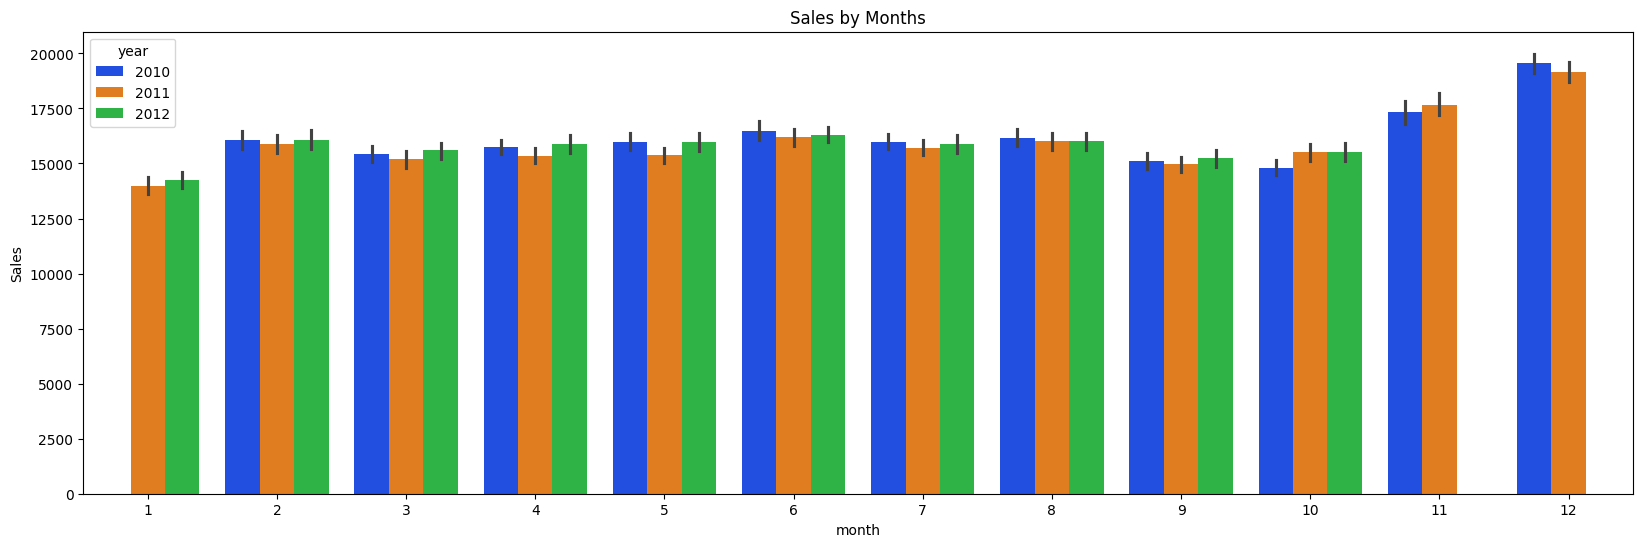

In [87]:
custom_colors = ["#58508d", "#bc5090", "#ff6361"] 
custom_cmap = ListedColormap(custom_colors)

plt.figure(figsize=(20, 6))
sns.barplot(data=features_cp, x='month', y='Weekly_Sales', hue='year', palette='bright').set_title('Sales by Months')
plt.ylabel('Sales')

plt.show()

## **Correlation Matrix For Feature Selection**

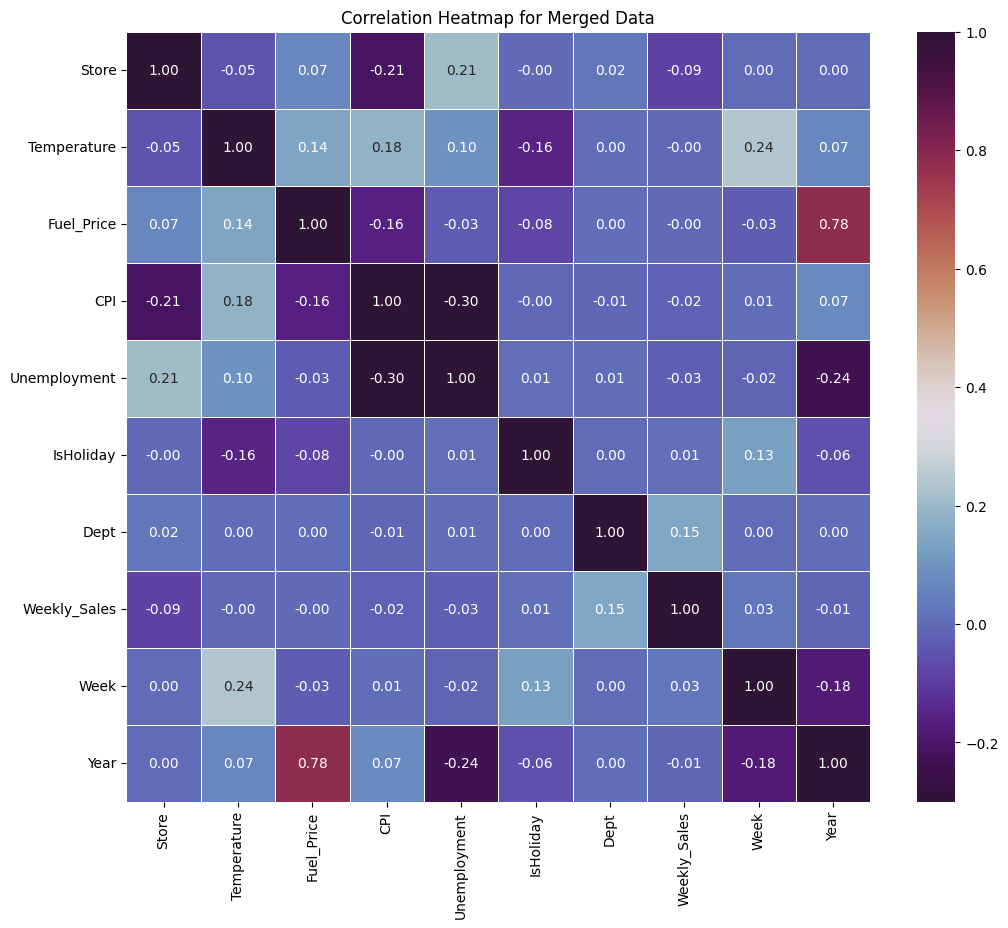

In [108]:
corr_matrix = merged_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='twilight_shifted', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Merged Data')
plt.show()

## **Finding Outliers**

In [135]:
column_names = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
statistics_features = features[column_names].describe().T
statistics_features['negative values'] = [features[col][features[col] < 0].count() for col in column_names]
statistics_features['null values'] = [features[col].isnull().sum() for col in column_names]
statistics_features['percentage of null values'] = [(features[col].isnull().sum() / len(features[col])) * 100 for col in column_names]
statistics_features = statistics_features.T
statistics_features

MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
count                        4032.00    2921.00    3613.00    3464.00   
mean                         7032.37    3384.18    1760.10    3292.94   
std                          9262.75    8793.58   11276.46    6792.33   
min                         -2781.45    -265.76    -179.26       0.22   
25%                          1577.53      68.88       6.60     304.69   
50%                          4743.58     364.57      36.26    1176.42   
75%                          8923.31    2153.35     163.15    3310.01   
max                        103184.98  104519.54  149483.31   67474.85   
negative values                 4.00      25.00      13.00       0.00   
null values                  4158.00    5269.00    4577.00    4726.00   
percentage of null values      50.77      64.33      55.89      57.70   

                           MarkDown5  
count                        4050.00  
mean                         4132.22  
std                         13086.69  
min                          -185.17  
25%                          1440.83  
50%                          2727.14  
75%                          4832.56  
max                        771448.10  
negative values                 2.00  
null values                  4140.00  
percentage of null values      50.55

### **Five_Number Summary**

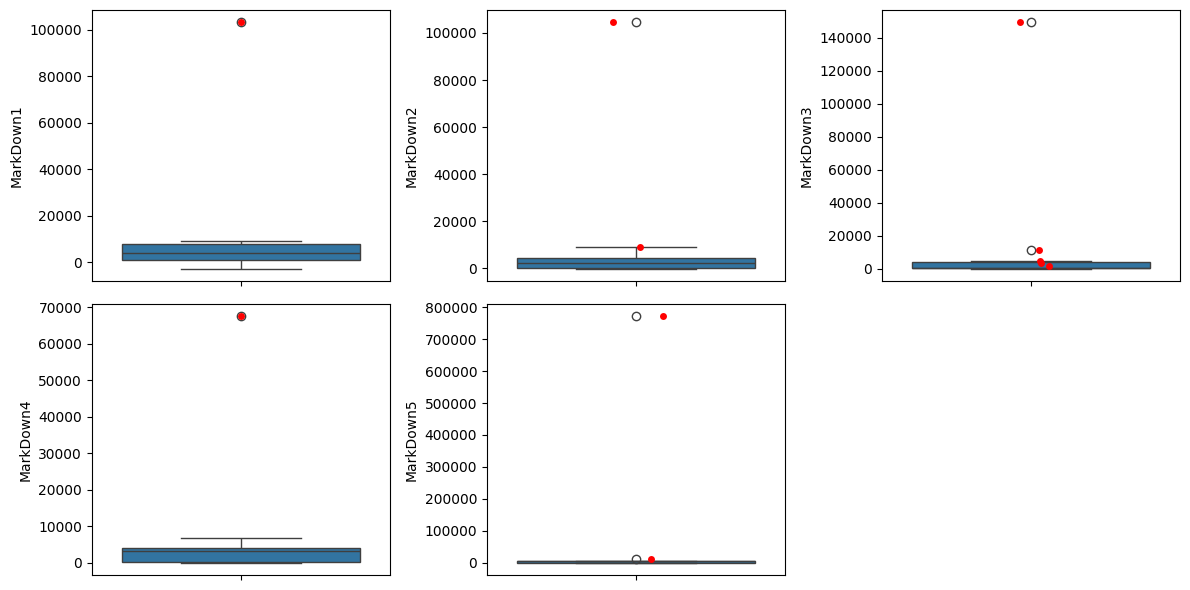

In [138]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)

    sns.boxplot(data=statistics_features, y=col)

    Q1 = statistics_features[col]['25%']
    Q3 = statistics_features[col]['75%']
    IQR = Q3 - Q1 # Inter quartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (statistics_features[col] < lower_bound) | (statistics_features[col] > upper_bound)  # 5 number summary

    sns.stripplot(data=statistics_features[outliers], y=col, color='red', jitter=True, size=5)

plt.tight_layout()
plt.show()

In [132]:
columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
fig = px.box(features, y=columns, points="all", title="Box Plot with Outliers")
fig.update_layout(
    xaxis_title="Columns",
    yaxis_title="Values",
    showlegend=False
)
fig.show()

### **Corrected the anamoly in Markdown5**

In [149]:
above_700k = features[features['MarkDown5'] > 700000]
above_700k

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
5059     28 2012-11-16        49.39        3.83   10431.55     184.51   

      MarkDown3  MarkDown4  MarkDown5    CPI  Unemployment  IsHoliday  
5059      42.72    1422.57  771448.10 131.33         10.20      False

##### **Checking how to handle outlier**

In [147]:
features.iloc[5049:5070]

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
5049     28 2012-09-07        88.52        4.12    7046.94      43.42   
5050     28 2012-09-14        83.64        4.13   15676.10       6.98   
5051     28 2012-09-21        82.97        4.12    8790.27     104.00   
5052     28 2012-09-28        81.22        3.97    5977.78       7.91   
5053     28 2012-10-05        81.61        3.97    4436.17        NaN   
5054     28 2012-10-12        71.74        4.47    1546.44        NaN   
5055     28 2012-10-19        68.66        4.45    2307.28        NaN   
5056     28 2012-10-26        65.95        4.30    6490.13      90.02   
5057     28 2012-11-02        63.22        4.10    9765.35    6729.72   
5058     28 2012-11-09        65.31        3.95   11066.79    7689.39   
5059     28 2012-11-16        49.39        3.83   10431.55     184.51   
5060     28 2012-11-23        58.07        3.76    1064.86        NaN   
5061     28 2012-11-30        57.03        3.58    2475.11        NaN   
5062     28 2012-12-07        57.83        3.67    9232.97        NaN   
5063     28 2012-12-14        49.74        3.47    3904.31        NaN   
5064     28 2012-12-21        42.83        3.39    3577.43      79.96   
5065     28 2012-12-28        43.35        3.48   12973.34   35919.80   
5066     28 2013-01-04        38.80        3.51    1529.20   28399.98   
5067     28 2013-01-11        44.59        3.54    6311.91    9225.86   
5068     28 2013-01-18        36.49        3.54    4908.90    1569.20   
5069     28 2013-01-25        49.21        3.34    4854.39    1931.93   

      MarkDown3  MarkDown4  MarkDown5    CPI  Unemployment  IsHoliday  
5049      66.08     701.38   11100.55 130.93         10.93       True  
5050      24.11    2180.72   10483.58 130.98         10.93      False  
5051       3.00    1761.30    9638.33 131.01         10.93      False  
5052       2.16    2458.50    6671.45 131.04         10.93      False  
5053      28.91    6563.84    8417.76 131.08         10.20      False  
5054      13.36    1057.73    6560.97 131.11         10.20      False  
5055       4.70    1406.03    4122.20 131.15         10.20      False  
5056        NaN    1750.84    1684.36 131.19         10.20      False  
5057      43.82    4608.92    7092.27 131.24         10.20      False  
5058      25.88    2816.22    6764.59 131.28         10.20      False  
5059      42.72    1422.57  771448.10 131.33         10.20      False  
5060   84493.38     515.22    1144.61 131.38         10.20       True  
5061    7879.62     438.16   31990.74 131.43         10.20      False  
5062     413.24    2404.59   12278.82 131.48         10.20      False  
5063     128.00     279.27    7181.55 131.54         10.20      False  
5064     122.92      36.29    2530.09 131.64         10.20      False  
5065     173.10      63.89    1894.52 131.75         10.20       True  
5066      17.51      15.74    4848.03 131.85          9.91      False  
5067       4.40     241.02    5898.01 131.96          9.91      False  
5068       1.02     296.82    5466.87 132.03          9.91      False  
5069       0.30     615.56    6698.98 132.09          9.91      False

In [150]:
condition = features['MarkDown5'] > 700000
features.loc[condition, 'MarkDown5'] /= 100

In [153]:
features.iloc[5059:5060]

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
5059     28 2012-11-16        49.39        3.83   10431.55     184.51   

      MarkDown3  MarkDown4  MarkDown5    CPI  Unemployment  IsHoliday  
5059      42.72    1422.57    7714.48 131.33         10.20      False

#### **Performin Deep Check on Data**

In [88]:
print('Stores :', sales[sales['Dept'] == 39]['Store'].unique())
print('Dept   :', sales[sales['Store']==39]['Dept'].unique())

Stores : [ 2  4 18 19 27]
Dept   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 38 40 41 42 44 45 46 47 49 51 52 54 55
 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94 95 96
 97 98 99]


In [166]:
merged_data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'])

In [167]:
merged_data = merged_data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)

In [168]:
merged_data['Week'] = merged_data['Date'].dt.isocalendar().week
merged_data['Year'] = merged_data['Date'].dt.year

In [169]:
merged_data.drop('Date', axis=1, inplace=True)

In [170]:
merged_data

Store  Temperature  Fuel_Price    CPI  Unemployment  IsHoliday  Dept  \
0           1        42.31        2.57 211.10          8.11      False     1   
1           1        42.31        2.57 211.10          8.11      False     2   
2           1        42.31        2.57 211.10          8.11      False     3   
3           1        42.31        2.57 211.10          8.11      False     4   
4           1        42.31        2.57 211.10          8.11      False     5   
...       ...          ...         ...    ...           ...        ...   ...   
421565     45        58.85        3.88 192.31          8.67      False    93   
421566     45        58.85        3.88 192.31          8.67      False    94   
421567     45        58.85        3.88 192.31          8.67      False    95   
421568     45        58.85        3.88 192.31          8.67      False    97   
421569     45        58.85        3.88 192.31          8.67      False    98   

        Weekly_Sales  Week  Year  
0           24924.50     5  2010  
1           50605.27     5  2010  
2           13740.12     5  2010  
3           39954.04     5  2010  
4           32229.38     5  2010  
...              ...   ...   ...  
421565       2487.80    43  2012  
421566       5203.31    43  2012  
421567      56017.47    43  2012  
421568       6817.48    43  2012  
421569       1076.80    43  2012  

[421570 rows x 10 columns]

In [171]:
focused_data = merged_data[merged_data['Store'] == 1]

In [172]:
focused_data

Store  Temperature  Fuel_Price    CPI  Unemployment  IsHoliday  Dept  \
0          1        42.31        2.57 211.10          8.11      False     1   
1          1        42.31        2.57 211.10          8.11      False     2   
2          1        42.31        2.57 211.10          8.11      False     3   
3          1        42.31        2.57 211.10          8.11      False     4   
4          1        42.31        2.57 211.10          8.11      False     5   
...      ...          ...         ...    ...           ...        ...   ...   
10239      1        69.16        3.51 223.44          6.57      False    94   
10240      1        69.16        3.51 223.44          6.57      False    95   
10241      1        69.16        3.51 223.44          6.57      False    96   
10242      1        69.16        3.51 223.44          6.57      False    97   
10243      1        69.16        3.51 223.44          6.57      False    98   

       Weekly_Sales  Week  Year  
0          24924.50     5  2010  
1          50605.27     5  2010  
2          13740.12     5  2010  
3          39954.04     5  2010  
4          32229.38     5  2010  
...             ...   ...   ...  
10239      60278.73    43  2012  
10240     117375.38    43  2012  
10241      36851.92    43  2012  
10242      32830.52    43  2012  
10243      12702.86    43  2012  

[10244 rows x 10 columns]

### **Checking for Nulls Before Modelling**

<Axes: >

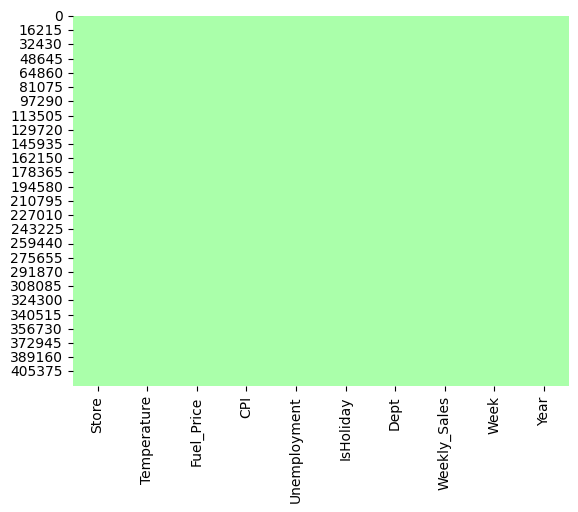

In [173]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(merged_data.isnull(), cmap=custom_cmap, cbar=False)

In [175]:
encoder = OrdinalEncoder()
merged_data['IsHoliday'] = encoder.fit_transform(merged_data[['IsHoliday']])

## **Train Test Split**

In [176]:
X = merged_data.drop('Weekly_Sales', axis=1)
y = merged_data['Weekly_Sales']

In [177]:
X.columns.unique()

Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday', 'Dept', 'Week', 'Year'],
      dtype='object')

In [178]:
X.shape, y.shape

((421570, 9), (421570,))

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **DO NOT RUN THIS AGAIN !!!!!!**

In [ ]:
# LR = LazyRegressor(verbose=0, ignore_warnings=False)
# models, predictions = LR.fit(x_train, x_test, y_train, y_test)

In [103]:
data = """
Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken
ExtraTreesRegressor,0.96,0.96,4630.90,177.48
RandomForestRegressor,0.93,0.93,5736.59,397.72
BaggingRegressor,0.93,0.93,5793.68,40.08
XGBRegressor,0.92,0.92,6225.55,1.51
LGBMRegressor,0.87,0.87,7831.10,0.93
HistGradientBoostingRegressor,0.87,0.87,7967.84,2.23
DecisionTreeRegressor,0.85,0.85,8368.61,5.27
ExtraTreeRegressor,0.83,0.83,9021.75,1.94
GradientBoostingRegressor,0.64,0.64,13195.39,35.01
KNeighborsRegressor,0.32,0.32,18135.77,9.17
MLPRegressor,0.15,0.15,20240.41,282.81
AdaBoostRegressor,0.04,0.04,21504.97,17.80
SGDRegressor,0.03,0.03,21585.19,2.08
Lasso,0.03,0.03,21586.97,0.36
LassoLars,0.03,0.03,21586.98,0.20
BayesianRidge,0.03,0.03,21587.00,0.30
RidgeCV,0.03,0.03,21587.01,0.38
Ridge,0.03,0.03,21587.01,0.20
LassoLarsIC,0.03,0.03,21587.01,0.33
LinearRegression,0.03,0.03,21587.01,0.23
TransformedTargetRegressor,0.03,0.03,21587.01,0.35
Lars,0.03,0.03,21587.01,0.27
LassoCV,0.03,0.03,21589.19,1.71
OrthogonalMatchingPursuitCV,0.03,0.03,21589.21,0.56
LassoLarsCV,0.03,0.03,21589.37,0.79
LarsCV,0.03,0.03,21589.37,0.85
ElasticNet,0.03,0.03,21632.86,0.23
OrthogonalMatchingPursuit,0.03,0.03,21688.29,0.21
TweedieRegressor,0.03,0.03,21688.34,0.34
ElasticNetCV,0.01,0.01,21819.44,1.55
DummyRegressor,-0.00,-0.00,21970.69,0.16
NuSVR,-0.03,-0.03,22312.51,13611.17
RANSACRegressor,-0.04,-0.04,22354.21,1.15
HuberRegressor,-0.08,-0.08,22784.61,0.89
SVR,-0.12,-0.12,23216.95,8694.55
PassiveAggressiveRegressor,-0.14,-0.14,23503.68,0.62
LinearSVR,-0.15,-0.15,23577.14,0.52
"""

df = pd.read_csv(StringIO(data), index_col='Model')

df

Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ExtraTreesRegressor                          0.96       0.96  4630.90   
RandomForestRegressor                        0.93       0.93  5736.59   
BaggingRegressor                             0.93       0.93  5793.68   
XGBRegressor                                 0.92       0.92  6225.55   
LGBMRegressor                                0.87       0.87  7831.10   
HistGradientBoostingRegressor                0.87       0.87  7967.84   
DecisionTreeRegressor                        0.85       0.85  8368.61   
ExtraTreeRegressor                           0.83       0.83  9021.75   
GradientBoostingRegressor                    0.64       0.64 13195.39   
KNeighborsRegressor                          0.32       0.32 18135.77   
MLPRegressor                                 0.15       0.15 20240.41   
AdaBoostRegressor                            0.04       0.04 21504.97   
SGDRegressor                                 0.03       0.03 21585.19   
Lasso                                        0.03       0.03 21586.97   
LassoLars                                    0.03       0.03 21586.98   
BayesianRidge                                0.03       0.03 21587.00   
RidgeCV                                      0.03       0.03 21587.01   
Ridge                                        0.03       0.03 21587.01   
LassoLarsIC                                  0.03       0.03 21587.01   
LinearRegression                             0.03       0.03 21587.01   
TransformedTargetRegressor                   0.03       0.03 21587.01   
Lars                                         0.03       0.03 21587.01   
LassoCV                                      0.03       0.03 21589.19   
OrthogonalMatchingPursuitCV                  0.03       0.03 21589.21   
LassoLarsCV                                  0.03       0.03 21589.37   
LarsCV                                       0.03       0.03 21589.37   
ElasticNet                                   0.03       0.03 21632.86   
OrthogonalMatchingPursuit                    0.03       0.03 21688.29   
TweedieRegressor                             0.03       0.03 21688.34   
ElasticNetCV                                 0.01       0.01 21819.44   
DummyRegressor                              -0.00      -0.00 21970.69   
NuSVR                                       -0.03      -0.03 22312.51   
RANSACRegressor                             -0.04      -0.04 22354.21   
HuberRegressor                              -0.08      -0.08 22784.61   
SVR                                         -0.12      -0.12 23216.95   
PassiveAggressiveRegressor                  -0.14      -0.14 23503.68   
LinearSVR                                   -0.15      -0.15 23577.14   

                               Time Taken  
Model                                      
ExtraTreesRegressor                177.48  
RandomForestRegressor              397.72  
BaggingRegressor                    40.08  
XGBRegressor                         1.51  
LGBMRegressor                        0.93  
HistGradientBoostingRegressor        2.23  
DecisionTreeRegressor                5.27  
ExtraTreeRegressor                   1.94  
GradientBoostingRegressor           35.01  
KNeighborsRegressor                  9.17  
MLPRegressor                       282.81  
AdaBoostRegressor                   17.80  
SGDRegressor                         2.08  
Lasso                                0.36  
LassoLars                            0.20  
BayesianRidge                        0.30  
RidgeCV                              0.38  
Ridge                                0.20  
LassoLarsIC                          0.33  
LinearRegression                     0.23  
TransformedTargetRegressor           0.35  
Lars                                 0.27  
LassoCV                              1.71  
OrthogonalMatchingPursuitCV          0.56  
LassoLarsCV                          0.

In [180]:
extra_trees_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

In [181]:
extra_trees_model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [182]:
y_pred = extra_trees_model.predict(X_test)

In [184]:
r2 = r2_score(y_test, y_pred)


In [188]:
r2*100

96.55659224453282

In [186]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [187]:
rmse

4254.745433438719

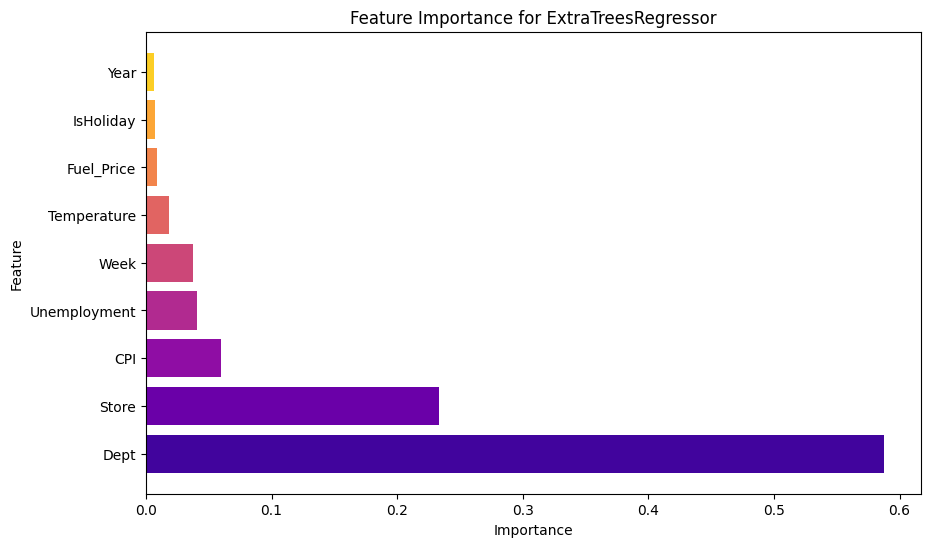

In [189]:
feature_importances = extra_trees_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

colors = sns.color_palette("plasma", n_colors=len(sorted_indices))

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importances[sorted_indices], color=colors)
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for ExtraTreesRegressor")
plt.show()

In [190]:
new_merged_data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'])

In [191]:
holidays = new_merged_data[new_merged_data['IsHoliday']==1]

<Axes: >

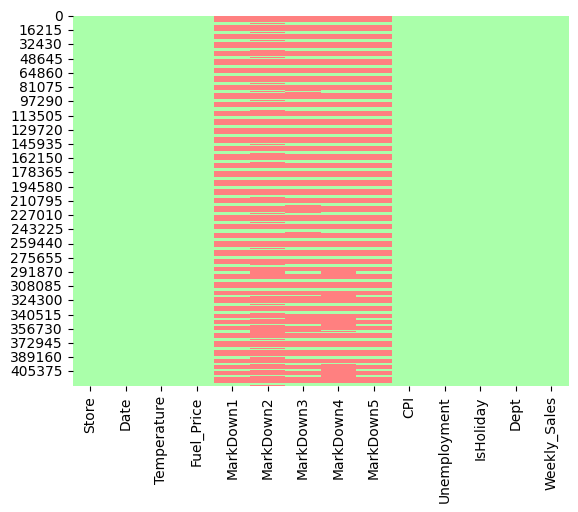

In [192]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(new_merged_data.isnull(), cmap=custom_cmap, cbar=False)

In [194]:
new_merged_data["MarkDown1"].fillna(0, inplace=True)
new_merged_data["MarkDown2"].fillna(0, inplace=True)
new_merged_data["MarkDown3"].fillna(0, inplace=True)
new_merged_data["MarkDown4"].fillna(0, inplace=True)
new_merged_data["MarkDown5"].fillna(0, inplace=True)

<Axes: >

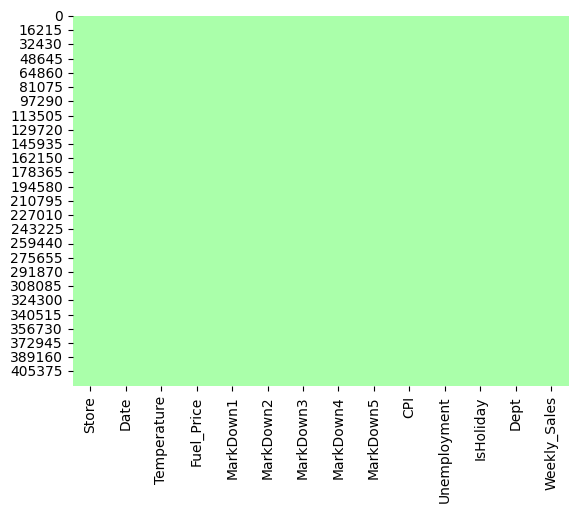

In [195]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(new_merged_data.isnull(), cmap=custom_cmap, cbar=False)

In [196]:
new_merged_data.drop(['Store','Temperature','Date','Fuel_Price','CPI','Unemployment','Dept','Weekly_Sales'], axis=1, inplace=True)

In [197]:
encoder = OrdinalEncoder()
new_merged_data['IsHoliday'] = encoder.fit_transform(new_merged_data[['IsHoliday']])

In [120]:
new_merged_data

MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  IsHoliday
0            0.00       0.00       0.00       0.00       0.00       0.00
1            0.00       0.00       0.00       0.00       0.00       0.00
2            0.00       0.00       0.00       0.00       0.00       0.00
3            0.00       0.00       0.00       0.00       0.00       0.00
4            0.00       0.00       0.00       0.00       0.00       0.00
...           ...        ...        ...        ...        ...        ...
421565    4018.91      58.08     100.00     211.94     858.33       0.00
421566    4018.91      58.08     100.00     211.94     858.33       0.00
421567    4018.91      58.08     100.00     211.94     858.33       0.00
421568    4018.91      58.08     100.00     211.94     858.33       0.00
421569    4018.91      58.08     100.00     211.94     858.33       0.00

[421570 rows x 6 columns]

In [198]:
X = new_merged_data.drop("IsHoliday", axis=1)
y = new_merged_data["IsHoliday"]

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Do not Run Again !!!**

In [80]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [19:55<02:26, 146.31s/it]

[LightGBM] [Info] Number of positive: 23525, number of negative: 313731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069754 -> initscore=-2.590472
[LightGBM] [Info] Start training from score -2.590472


100%|██████████| 29/29 [19:56<00:00, 41.26s/it] 


In [81]:
# models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.96               0.70     0.70      0.95   
KNeighborsClassifier               0.96               0.70     0.70      0.95   
XGBClassifier                      0.96               0.70     0.70      0.95   
RandomForestClassifier             0.96               0.70     0.70      0.95   
DecisionTreeClassifier             0.96               0.70     0.70      0.95   
BaggingClassifier                  0.96               0.70     0.70      0.95   
ExtraTreeClassifier                0.96               0.70     0.70      0.95   
ExtraTreesClassifier               0.96               0.70     0.70      0.95   
SVC                                0.94               0.62     0.62      0.93   
AdaBoostClassifier                 0.94               0.59     0.59      0.92   
NearestCentroid                    0.91               0.59     0.59      0.90   
QuadraticDiscriminantAnalysis      0.93               0.58     0.58      0.91   
GaussianNB                         0.93               0.58     0.58      0.91   
LinearDiscriminantAnalysis         0.93               0.58     0.58      0.91   
CategoricalNB                      0.94               0.58     0.58      0.92   
LogisticRegression                 0.94               0.58     0.58      0.92   
CalibratedClassifierCV             0.94               0.57     0.57      0.92   
LinearSVC                          0.94               0.57     0.57      0.91   
RidgeClassifier                    0.94               0.57     0.57      0.91   
RidgeClassifierCV                  0.94               0.57     0.57      0.91   
Perceptron                         0.94               0.56     0.56      0.91   
SGDClassifier                      0.94               0.56     0.56      0.91   
PassiveAggressiveClassifier        0.93               0.51     0.51      0.90   
DummyClassifier                    0.93               0.50     0.50      0.89   
BernoulliNB                        0.93               0.50     0.50      0.89   

                               Time Taken  
Model                                      
LGBMClassifier                       1.06  
KNeighborsClassifier               169.69  
XGBClassifier                        0.98  
RandomForestClassifier              20.38  
DecisionTreeClassifier               0.59  
BaggingClassifier                    3.75  
ExtraTreeClassifier                  0.34  
ExtraTreesClassifier                15.64  
SVC                                897.34  
AdaBoostClassifier                   8.99  
NearestCentroid                      0.24  
QuadraticDiscriminantAnalysis        0.26  
GaussianNB                           0.24  
LinearDiscriminantAnalysis           0.34  
CategoricalNB                        0.32  
LogisticRegression                   0.50  
CalibratedClassifierCV               4.31  
LinearSVC                           68.46  
RidgeClassifier                      0.27  
RidgeClassifierCV                    0.35  
Perceptron                           0.59  
SGDClassifier                        0.65  
PassiveAggressiveClassifier          0.50  
DummyClassifier                      0.19  
BernoulliNB                          0.26

In [200]:
dt_classifier = DecisionTreeClassifier(random_state=42)

In [201]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [202]:
y_pred = dt_classifier.predict(X_test)

In [204]:
accuracy = accuracy_score(y_test, y_pred)
accuracy*100

95.66738619920773

In [205]:
feature_importances = dt_classifier.feature_importances_

## **Influence of MarkDowns on Holiday weeks**

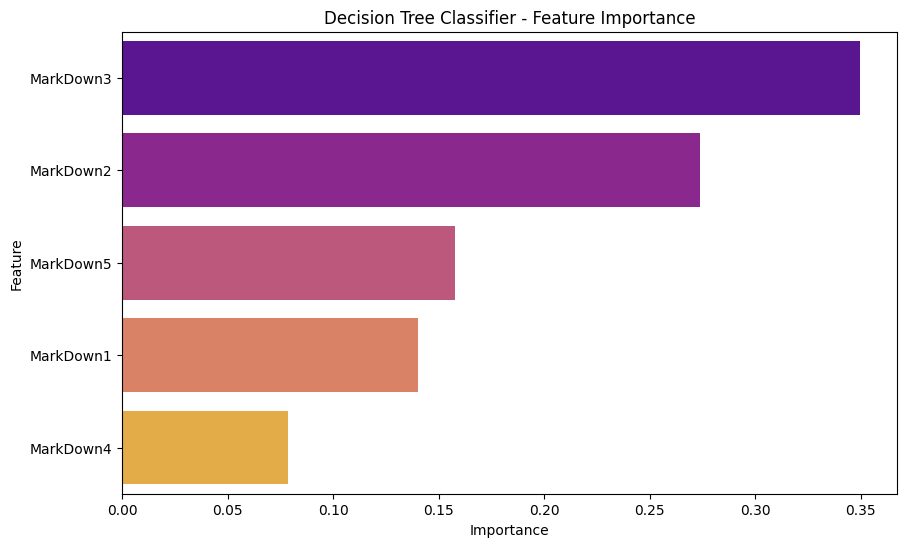

In [206]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='plasma')
plt.title('Decision Tree Classifier - Feature Importance')
plt.show()

In [213]:
df = sales.merge(features,how="left", on=['Store', 'Date', 'IsHoliday'])
correlation_matrix = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']].corr()
correlation_matrix

MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
MarkDown1          1.00       0.02      -0.11       0.82       0.16   
MarkDown2          0.02       1.00      -0.05      -0.01      -0.01   
MarkDown3         -0.11      -0.05       1.00      -0.07      -0.03   
MarkDown4          0.82      -0.01      -0.07       1.00       0.11   
MarkDown5          0.16      -0.01      -0.03       0.11       1.00   
Weekly_Sales       0.09       0.02       0.06       0.05       0.09   

              Weekly_Sales  
MarkDown1             0.09  
MarkDown2             0.02  
MarkDown3             0.06  
MarkDown4             0.05  
MarkDown5             0.09  
Weekly_Sales          1.00

<Axes: >

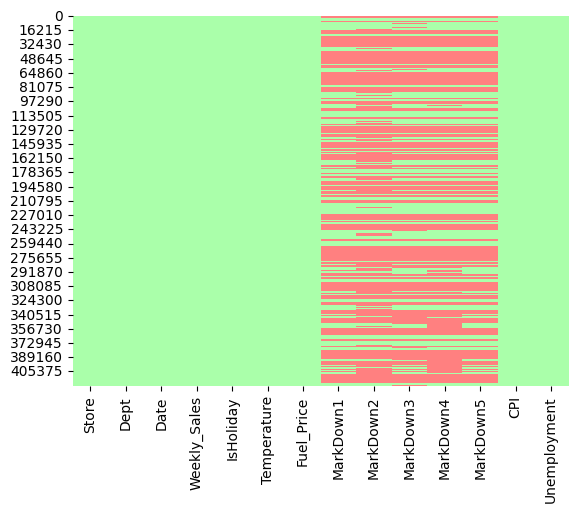

In [217]:
custom_cmap = ListedColormap(['#aaffaa', '#ffffff', '#ffaaaa', '#ff8080'])
sns.heatmap(df.isnull(), cmap=custom_cmap, cbar=False)

In [218]:
df["MarkDown1"].fillna(0, inplace=True)
df["MarkDown2"].fillna(0, inplace=True)
df["MarkDown3"].fillna(0, inplace=True)
df["MarkDown4"].fillna(0, inplace=True)
df["MarkDown5"].fillna(0, inplace=True)

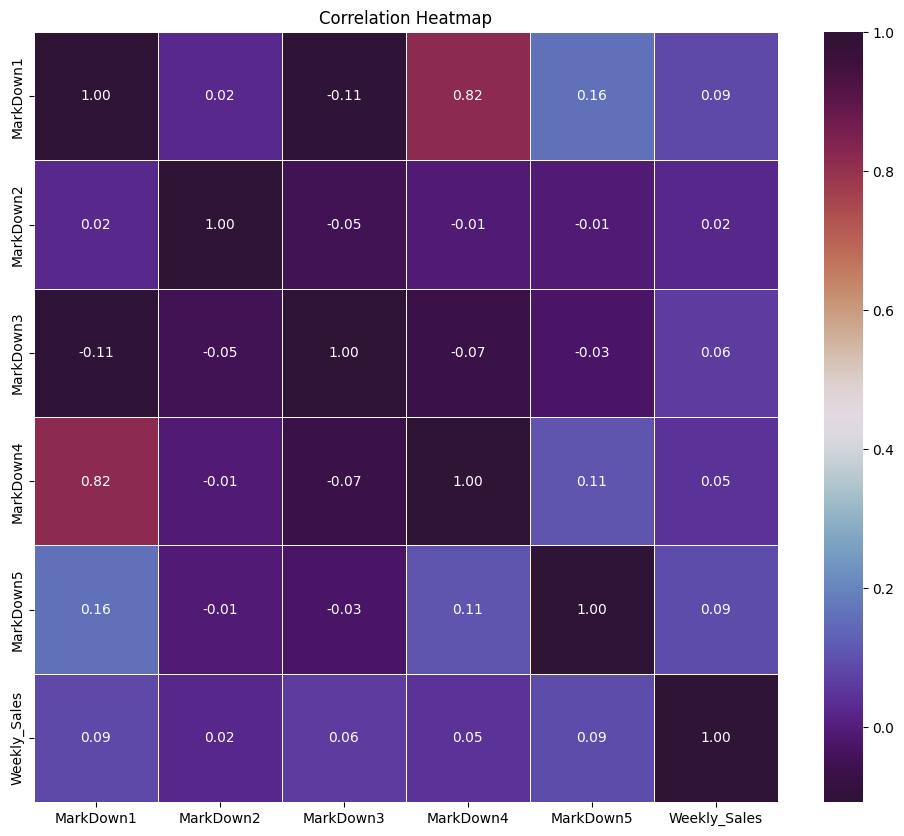

In [219]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='twilight_shifted', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## **Data to train**

In [816]:
merged_data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'])
merged_data = merged_data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)
merged_data['Week'] = merged_data['Date'].dt.isocalendar().week
merged_data['Year'] = merged_data['Date'].dt.year

In [818]:
test_sample = merged_data[merged_data['Store']==4]

In [819]:
test_sample['IsHoliday'] = test_sample['IsHoliday'].astype(int)

In [820]:
test_sample_sum = test_sample.groupby('Date')['Weekly_Sales'].sum().reset_index()

In [821]:
test_sample_sum

Date  Weekly_Sales
0   2010-02-05    2135143.87
1   2010-02-12    2188307.39
2   2010-02-19    2049860.26
3   2010-02-26    1925728.84
4   2010-03-05    1971057.44
..         ...           ...
138 2012-09-28    2027620.23
139 2012-10-05    2209835.43
140 2012-10-12    2133026.07
141 2012-10-19    2097266.85
142 2012-10-26    2149594.46

[143 rows x 2 columns]

In [823]:
test_sample_features = test_sample.drop(columns=['Weekly_Sales','Dept'])

In [824]:
test_sample_features = test_sample_features.drop_duplicates().reset_index(drop=True)

In [828]:
test_sample_features.head()

Store       Date  Temperature  Fuel_Price    CPI  Unemployment  IsHoliday  \
0      4 2010-02-05        43.76        2.60 126.44          8.62          0   
1      4 2010-02-12        28.84        2.57 126.50          8.62          1   
2      4 2010-02-19        36.45        2.54 126.53          8.62          0   
3      4 2010-02-26        41.36        2.59 126.55          8.62          0   
4      4 2010-03-05        43.49        2.65 126.58          8.62          0   

   Week  Year  
0     5  2010  
1     6  2010  
2     7  2010  
3     8  2010  
4     9  2010

In [829]:
merged_test_sample = pd.merge(test_sample_features, test_sample_sum, on='Date', how='inner')

In [830]:
merged_test_sample = merged_test_sample.drop(columns='Store')

In [869]:
merged_test_sample

Date  Temperature  Fuel_Price    CPI  Unemployment  IsHoliday  Week  \
6   2010-03-19        55.19        2.74 126.61          8.62          0    11   
7   2010-03-26        39.91        2.75 126.61          8.62          0    12   
8   2010-04-02        48.77        2.74 126.60          7.90          0    13   
9   2010-04-09        54.16        2.77 126.60          7.90          0    14   
10  2010-04-16        56.23        2.81 126.56          7.90          0    15   
..         ...          ...         ...    ...           ...        ...   ...   
138 2012-09-28        71.74        3.67 131.04          4.08          0    39   
139 2012-10-05        63.07        3.62 131.08          3.88          0    40   
140 2012-10-12        57.11        3.60 131.11          3.88          0    41   
141 2012-10-19        64.46        3.61 131.15          3.88          0    42   
142 2012-10-26        63.64        3.51 131.19          3.88          0    43   

     Year  Weekly_Sales  differenced_data  
6    2010    1897429.36        -237714.51  
7    2010    1762539.30        -425768.09  
8    2010    1979247.12         -70613.14  
9    2010    1818452.72        -107276.12  
10   2010    1851519.69        -119537.75  
..    ...           ...               ...  
138  2012    2027620.23        -255920.07  
139  2012    2209835.43          84593.75  
140  2012    2133026.07          51844.72  
141  2012    2097266.85         -27837.87  
142  2012    2149594.46          31739.86  

[137 rows x 10 columns]

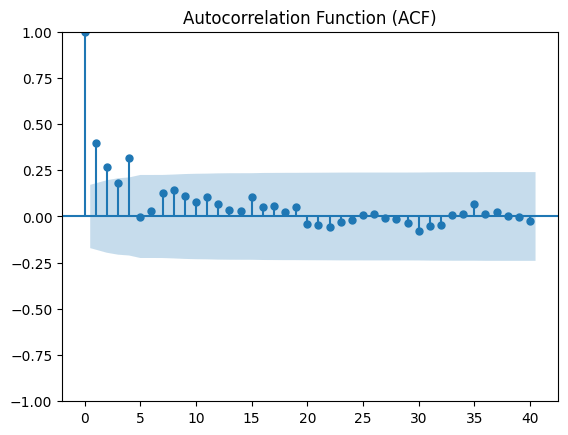

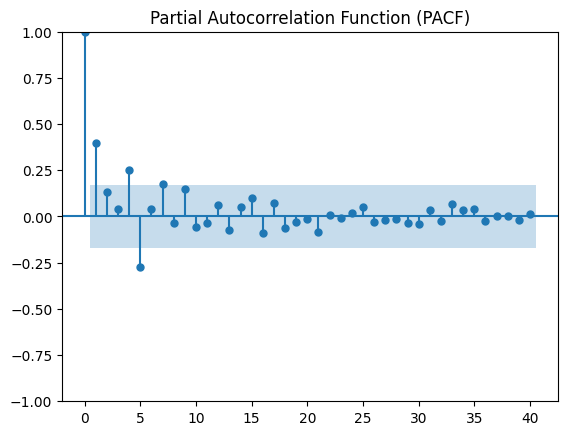

In [851]:
target_variable = 'Weekly_Sales'

plot_acf(merged_test_sample[target_variable], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(merged_test_sample[target_variable], lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [934]:
def preprocess_data(features, sales, store_id):
    merged_data = pd.merge(features, sales, on=['Store', 'Date', 'IsHoliday'])
    merged_data = merged_data.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)
    merged_data['Week'] = merged_data['Date'].dt.isocalendar().week
    merged_data['Year'] = merged_data['Date'].dt.year

    test_sample = merged_data[merged_data['Store'] == store_id]
    test_sample['IsHoliday'] = test_sample['IsHoliday'].astype(int)

    test_sample_sum = test_sample.groupby('Date')['Weekly_Sales'].sum().reset_index()

    test_sample_features = test_sample.drop(columns=['Weekly_Sales', 'Dept'])
    test_sample_features = test_sample_features.drop_duplicates().reset_index(drop=True)

    merged_test_sample = pd.merge(test_sample_features, test_sample_sum, on='Date', how='inner')
    merged_test_sample = merged_test_sample.drop(columns='Store')

    return merged_test_sample

def adf_test(data, column_name='Weekly_Sales'):
    test_result = adfuller(data[column_name])
    print('ADF Statistic:', test_result[0])
    print('p-value:', test_result[1])
    print('Critical Values:', test_result[4])

def difference_data(data, column_name='Weekly_Sales', shift_value=2):
    data['differenced_data'] = data[column_name] - data[column_name].shift(shift_value)
    data = data.dropna()
    data['differenced_data'].plot()
    return data

def train_test_split_data(data, train_size=0.8):
    sample_train, sample_test = train_test_split(data, train_size=train_size)
    return sample_train, sample_test

def build_auto_arima_model(train_data, exog_cols, seasonal_order=(52, 1, 0, 1)):
    model = auto_arima(
        train_data['differenced_data'],
        exogenous=train_data[exog_cols],
        seasonal=True,
        m=seasonal_order[0],
        D=seasonal_order[1],
    )
    return model

def visualize_predictions(actual_data, predictions_df):
    plt.figure(figsize=(18, 6))
    plt.plot(actual_data.index, actual_data['differenced_data'], label='Actual', color='blue')
    plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted', color='red')
    plt.fill_between(predictions_df.index, predictions_df['Lower_CI'], predictions_df['Upper_CI'], color='pink', alpha=0.3)

    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.title('Actual vs Predicted Weekly Sales')
    plt.legend()

    plt.show()


In [935]:
store_id = 4
merged_test_sample = preprocess_data(features, sales, store_id)
adf_test(merged_test_sample, column_name='Weekly_Sales')

ADF Statistic: -2.879381984014712
p-value: 0.04779866223669839
Critical Values: {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}


ADF Statistic: -4.881669386220674
p-value: 3.7855672392253905e-05
Critical Values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}


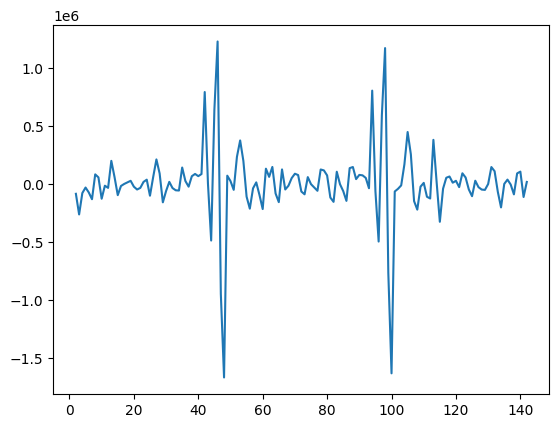

In [936]:
merged_test_sample = difference_data(merged_test_sample)
adf_test(merged_test_sample, column_name='differenced_data')

In [937]:
sample_train, sample_test = train_test_split_data(merged_test_sample)
exog_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Week', 'Year']
model = build_auto_arima_model(sample_train, exog_cols)
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  112
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood                -775.584
Date:                             Wed, 15 Nov 2023   AIC                           1557.168
Time:                                     04:26:44   BIC                           1563.451
Sample:                                          0   HQIC                          1559.625
                                             - 112                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3145      0.100      3.142      0.002       0.118       0.511
ar.S.L52      -0.0724      

In [938]:
model

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [939]:
forecast, conf_int = model.predict(len(sample_test), exogenous=sample_test[exog_cols], return_conf_int=True)
forecast.reset_index(drop=True, inplace=True)
forecast_df = pd.DataFrame({'Forecast': forecast})
forecast_df['Date'] = sample_test.index
forecast_df.set_index('Date', inplace=True)
predictions_df = pd.DataFrame({
    'Predicted': forecast_df['Forecast'],
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
}, index=sample_test.index)

In [932]:
predictions_df.head()

Predicted   Lower_CI  Upper_CI
115  111714.01 -105617.79 329045.80
116  -58408.25 -275740.05 158923.54
117  171024.92  -46306.88 388356.71
118  -65002.46 -282334.26 152329.33
119   62564.35 -154767.45 279896.14

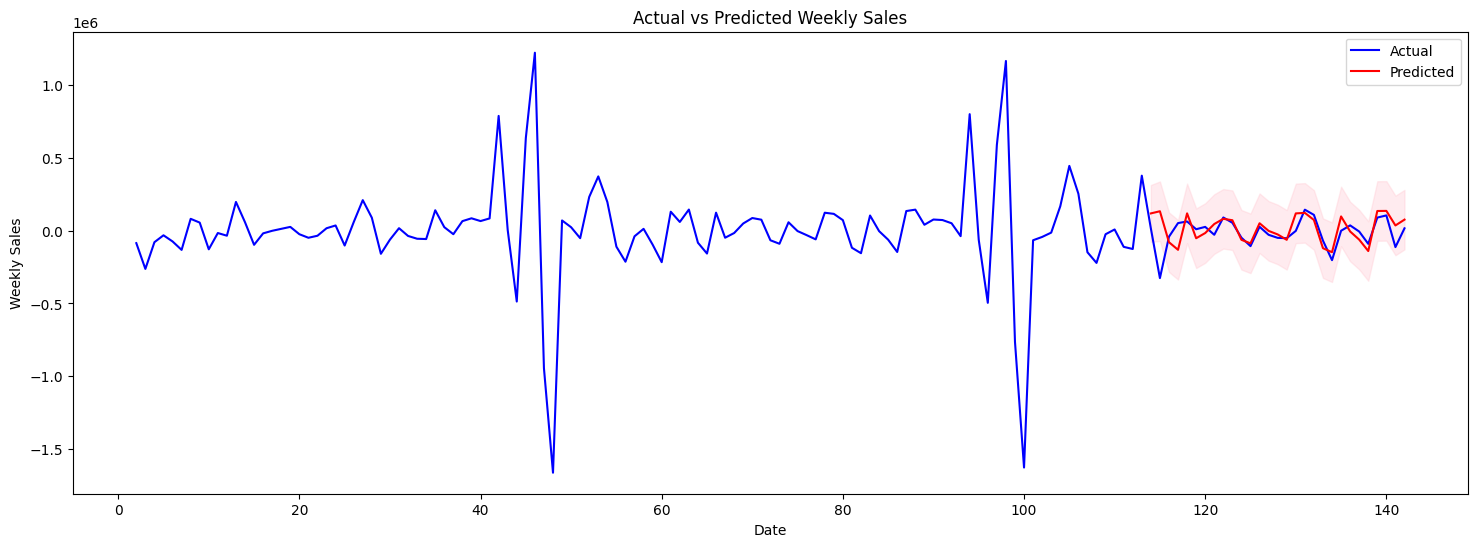

In [940]:
visualize_predictions(merged_test_sample, predictions_df)

In [887]:
features_test = features[features['Store']==4]

In [888]:
features_test.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)

In [889]:
features_test = features_test[143:]

In [891]:
features_test['Week'] = features_test['Date'].dt.isocalendar().week
features_test['Year'] = features_test['Date'].dt.year

In [892]:
features_test.drop('Store', axis=1, inplace=True)

In [893]:
features_test['IsHoliday'] = features_test['IsHoliday'].astype(int)

In [894]:
features_test = features_test.dropna()

In [895]:
features_test.set_index('Date', inplace=True)

In [ ]:
data = """
Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken
ExtraTreesRegressor,0.96,0.96,4630.90,177.48
RandomForestRegressor,0.93,0.93,5736.59,397.72
BaggingRegressor,0.93,0.93,5793.68,40.08
XGBRegressor,0.92,0.92,6225.55,1.51
LGBMRegressor,0.87,0.87,7831.10,0.93
HistGradientBoostingRegressor,0.87,0.87,7967.84,2.23
DecisionTreeRegressor,0.85,0.85,8368.61,5.27
ExtraTreeRegressor,0.83,0.83,9021.75,1.94
GradientBoostingRegressor,0.64,0.64,13195.39,35.01
KNeighborsRegressor,0.32,0.32,18135.77,9.17
MLPRegressor,0.15,0.15,20240.41,282.81
AdaBoostRegressor,0.04,0.04,21504.97,17.80
SGDRegressor,0.03,0.03,21585.19,2.08
Lasso,0.03,0.03,21586.97,0.36
LassoLars,0.03,0.03,21586.98,0.20
BayesianRidge,0.03,0.03,21587.00,0.30
RidgeCV,0.03,0.03,21587.01,0.38
Ridge,0.03,0.03,21587.01,0.20
LassoLarsIC,0.03,0.03,21587.01,0.33
LinearRegression,0.03,0.03,21587.01,0.23
TransformedTargetRegressor,0.03,0.03,21587.01,0.35
Lars,0.03,0.03,21587.01,0.27
LassoCV,0.03,0.03,21589.19,1.71
OrthogonalMatchingPursuitCV,0.03,0.03,21589.21,0.56
LassoLarsCV,0.03,0.03,21589.37,0.79
LarsCV,0.03,0.03,21589.37,0.85
ElasticNet,0.03,0.03,21632.86,0.23
OrthogonalMatchingPursuit,0.03,0.03,21688.29,0.21
TweedieRegressor,0.03,0.03,21688.34,0.34
ElasticNetCV,0.01,0.01,21819.44,1.55
DummyRegressor,-0.00,-0.00,21970.69,0.16
NuSVR,-0.03,-0.03,22312.51,13611.17
RANSACRegressor,-0.04,-0.04,22354.21,1.15
HuberRegressor,-0.08,-0.08,22784.61,0.89
SVR,-0.12,-0.12,23216.95,8694.55
PassiveAggressiveRegressor,-0.14,-0.14,23503.68,0.62
LinearSVR,-0.15,-0.15,23577.14,0.52
"""

df = pd.read_csv(StringIO(data), index_col='Model')

df

Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ExtraTreesRegressor                          0.96       0.96  4630.90   
RandomForestRegressor                        0.93       0.93  5736.59   
BaggingRegressor                             0.93       0.93  5793.68   
XGBRegressor                                 0.92       0.92  6225.55   
LGBMRegressor                                0.87       0.87  7831.10   
HistGradientBoostingRegressor                0.87       0.87  7967.84   
DecisionTreeRegressor                        0.85       0.85  8368.61   
ExtraTreeRegressor                           0.83       0.83  9021.75   
GradientBoostingRegressor                    0.64       0.64 13195.39   
KNeighborsRegressor                          0.32       0.32 18135.77   
MLPRegressor                                 0.15       0.15 20240.41   
AdaBoostRegressor                            0.04       0.04 21504.97   
SGDRegressor                                 0.03       0.03 21585.19   
Lasso                                        0.03       0.03 21586.97   
LassoLars                                    0.03       0.03 21586.98   
BayesianRidge                                0.03       0.03 21587.00   
RidgeCV                                      0.03       0.03 21587.01   
Ridge                                        0.03       0.03 21587.01   
LassoLarsIC                                  0.03       0.03 21587.01   
LinearRegression                             0.03       0.03 21587.01   
TransformedTargetRegressor                   0.03       0.03 21587.01   
Lars                                         0.03       0.03 21587.01   
LassoCV                                      0.03       0.03 21589.19   
OrthogonalMatchingPursuitCV                  0.03       0.03 21589.21   
LassoLarsCV                                  0.03       0.03 21589.37   
LarsCV                                       0.03       0.03 21589.37   
ElasticNet                                   0.03       0.03 21632.86   
OrthogonalMatchingPursuit                    0.03       0.03 21688.29   
TweedieRegressor                             0.03       0.03 21688.34   
ElasticNetCV                                 0.01       0.01 21819.44   
DummyRegressor                              -0.00      -0.00 21970.69   
NuSVR                                       -0.03      -0.03 22312.51   
RANSACRegressor                             -0.04      -0.04 22354.21   
HuberRegressor                              -0.08      -0.08 22784.61   
SVR                                         -0.12      -0.12 23216.95   
PassiveAggressiveRegressor                  -0.14      -0.14 23503.68   
LinearSVR                                   -0.15      -0.15 23577.14   

                               Time Taken  
Model                                      
ExtraTreesRegressor                177.48  
RandomForestRegressor              397.72  
BaggingRegressor                    40.08  
XGBRegressor                         1.51  
LGBMRegressor                        0.93  
HistGradientBoostingRegressor        2.23  
DecisionTreeRegressor                5.27  
ExtraTreeRegressor                   1.94  
GradientBoostingRegressor           35.01  
KNeighborsRegressor                  9.17  
MLPRegressor                       282.81  
AdaBoostRegressor                   17.80  
SGDRegressor                         2.08  
Lasso                                0.36  
LassoLars                            0.20  
BayesianRidge                        0.30  
RidgeCV                              0.38  
Ridge                                0.20  
LassoLarsIC                          0.33  
LinearRegression                     0.23  
TransformedTargetRegressor           0.35  
Lars                                 0.27  
LassoCV                              1.71  
OrthogonalMatchingPursuitCV          0.56  
LassoLarsCV                          0.

In [896]:
forecast, conf_int = model.predict(len(features_test), exogenous=features_test[exog_cols], return_conf_int=True)

In [957]:
features_ex = features[features['Store']==4]

In [958]:
features_ex.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)

In [959]:
features_ex = features_ex.dropna()

In [960]:
features_ex.drop('Store', axis=1, inplace=True)

In [961]:
features_ex['Week'] = features_ex['Date'].dt.isocalendar().week
features_ex['Year'] = features_ex['Date'].dt.year

In [962]:
features_ex.set_index('Date', inplace=True)

In [963]:
features_ex['IsHoliday'] = features_ex['IsHoliday'].astype(int)

In [964]:
features_ex

Temperature  Fuel_Price    CPI  Unemployment  IsHoliday  Week  \
Date                                                                        
2010-02-05        43.76        2.60 126.44          8.62          0     5   
2010-02-12        28.84        2.57 126.50          8.62          1     6   
2010-02-19        36.45        2.54 126.53          8.62          0     7   
2010-02-26        41.36        2.59 126.55          8.62          0     8   
2010-03-05        43.49        2.65 126.58          8.62          0     9   
...                 ...         ...    ...           ...        ...   ...   
2013-03-29        50.36        3.58 132.59          3.92          0    13   
2013-04-05        57.70        3.55 132.65          3.90          0    14   
2013-04-12        60.06        3.50 132.72          3.90          0    15   
2013-04-19        63.28        3.44 132.72          3.90          0    16   
2013-04-26        58.15        3.40 132.72          3.90          0    17   

            Year  
Date              
2010-02-05  2010  
2010-02-12  2010  
2010-02-19  2010  
2010-02-26  2010  
2010-03-05  2010  
...          ...  
2013-03-29  2013  
2013-04-05  2013  
2013-04-12  2013  
2013-04-19  2013  
2013-04-26  2013  

[169 rows x 7 columns]

In [941]:
test_sample_sum.set_index('Date', inplace=True)

In [943]:
test_sample_sum

Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44
...                  ...
2012-09-28    2027620.23
2012-10-05    2209835.43
2012-10-12    2133026.07
2012-10-19    2097266.85
2012-10-26    2149594.46

[143 rows x 1 columns]

In [965]:
final_merge = pd.merge(features_ex, test_sample_sum, on='Date', how='left')

In [966]:
test_final_merge = final_merge[143:]

In [967]:
test_final_merge.drop('Weekly_Sales', axis=1, inplace=True)

In [968]:
test_final_merge

Temperature  Fuel_Price    CPI  Unemployment  IsHoliday  Week  \
Date                                                                        
2012-11-02        53.31        3.40 131.24          3.88          0    44   
2012-11-09        59.47        3.34 131.28          3.88          0    45   
2012-11-16        49.86        3.27 131.33          3.88          0    46   
2012-11-23        55.09        3.23 131.38          3.88          1    47   
2012-11-30        50.91        3.24 131.43          3.88          0    48   
2012-12-07        53.67        3.23 131.48          3.88          0    49   
2012-12-14        42.57        3.19 131.54          3.88          0    50   
2012-12-21        44.80        3.11 131.64          3.88          0    51   
2012-12-28        37.93        3.12 131.75          3.88          1    52   
2013-01-04        33.11        3.18 131.85          3.92          0     1   
2013-01-11        38.92        3.23 131.96          3.92          0     2   
2013-01-18        34.06        3.23 132.03          3.92          0     3   
2013-01-25        47.49        3.22 132.09          3.92          0     4   
2013-02-01        49.07        3.23 132.15          3.92          0     5   
2013-02-08        49.86        3.40 132.22          3.92          1     6   
2013-02-15        44.70        3.45 132.27          3.92          0     7   
2013-02-22        44.68        3.60 132.32          3.92          0     8   
2013-03-01        42.56        3.69 132.37          3.92          0     9   
2013-03-08        53.21        3.65 132.42          3.92          0    10   
2013-03-15        53.39        3.61 132.47          3.92          0    11   
2013-03-22        58.55        3.59 132.53          3.92          0    12   
2013-03-29        50.36        3.58 132.59          3.92          0    13   
2013-04-05        57.70        3.55 132.65          3.90          0    14   
2013-04-12        60.06        3.50 132.72          3.90          0    15   
2013-04-19        63.28        3.44 132.72          3.90          0    16   
2013-04-26        58.15        3.40 132.72          3.90          0    17   

            Year  
Date              
2012-11-02  2012  
2012-11-09  2012  
2012-11-16  2012  
2012-11-23  2012  
2012-11-30  2012  
2012-12-07  2012  
2012-12-14  2012  
2012-12-21  2012  
2012-12-28  2012  
2013-01-04  2013  
2013-01-11  2013  
2013-01-18  2013  
2013-01-25  2013  
2013-02-01  2013  
2013-02-08  2013  
2013-02-15  2013  
2013-02-22  2013  
2013-03-01  2013  
2013-03-08  2013  
2013-03-15  2013  
2013-03-22  2013  
2013-03-29  2013  
2013-04-05  2013  
2013-04-12  2013  
2013-04-19  2013  
2013-04-26  2013

In [969]:
forecast, conf_int = model.predict(len(test_final_merge), exogenous=test_final_merge[exog_cols], return_conf_int=True)

In [971]:
forecast.reset_index(drop=True, inplace=True)
forecast_df = pd.DataFrame({'Forecast': forecast})
forecast_df['Date'] = test_final_merge.index
forecast_df.set_index('Date', inplace=True)
predictions_df = pd.DataFrame({
    'Predicted': forecast_df['Forecast'],
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
}, index=test_final_merge.index)

<Axes: xlabel='Date'>

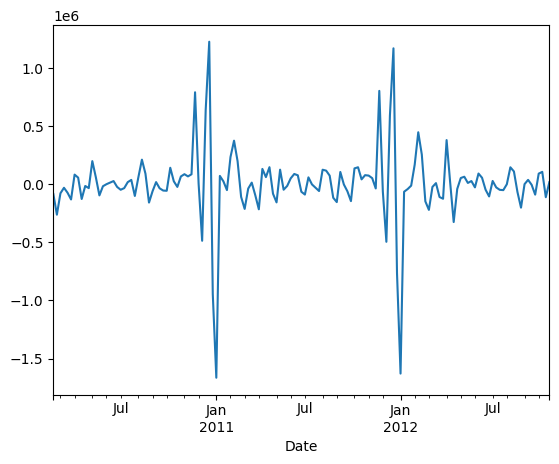

In [977]:
test_sample_sum['differenced_data'] = test_sample_sum['Weekly_Sales'] - test_sample_sum['Weekly_Sales'].shift(2)
test_sample_sum = test_sample_sum.dropna()
test_sample_sum['differenced_data'].plot()

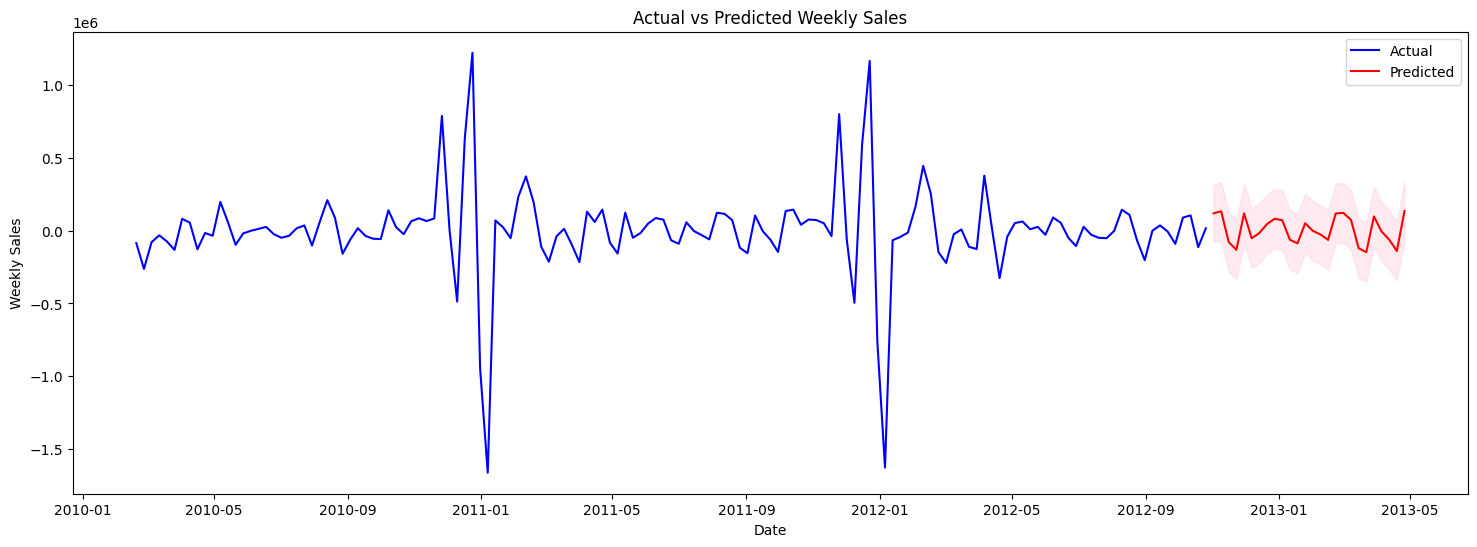

In [978]:
plt.figure(figsize=(18, 6))
plt.plot(test_sample_sum.index, test_sample_sum['differenced_data'], label='Actual', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted', color='red')
plt.fill_between(predictions_df.index, predictions_df['Lower_CI'], predictions_df['Upper_CI'], color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()

plt.show()